# The Transformation and Accept/Reject (aka. Von Neumann) methods 
Python notebook with exercise on how to generate random numbers following a specific PDF using uniformly distributed random numbers, in this case three different functions, each with their own challenge.

Both the Accept-Reject (Von Neumann) and transformation method should be considered for the problem (or a combination of both!):
- Transformation method (if function can be integrated and then inverted).
- Accept-Reject (or Hit & Miss) method (by Ulam Stanislav and John Von Neumann).

### References:
- G. Cowan: Chapter 3
- P. R. Bevington: page 81-84
- __[40. Monte Carlo Techniques PDG](http://pdg.lbl.gov/2020/reviews/rpp2020-rev-monte-carlo-techniques.pdf)__

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 29-11-2022 (latest update)

***

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
import sympy as sp

Load external functions:

In [2]:
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

Set the parameters of the program:

In [3]:
r = np.random
r.seed(42)

save_plots = False  
N_points = 10000    # Number of random points to be generated

## Problem 1: 

#### Produce random points following $f(x) \sim \exp(-x/3), x \in [0, \infty]$.

In [4]:
# Define a reasonable range to plot in:
xmin = 0
xmax = 20
N_bins = 100

x_exp = 20.0*r.uniform(size=N_points)     # This is NOT the solution - just something to plot!

And to make sure that we have computed the points correctly, we plot a histogram of the data:

In [28]:
def anal_monte_carlo(f, var, range, N_points, random):
    F = sp.integrate(f, (var, range[0], var))
    integral = sp.integrate(f, (var, *range))
    F = F/integral
    F_func = sp.lambdify(var, F)
    u = sp.symbols('u', positive = True)
    inverse = sp.solve(F - u, var)[0]
    inverse_func = sp.lambdify(u, inverse)
    us = random.uniform(size = N_points)
    return inverse_func(us)

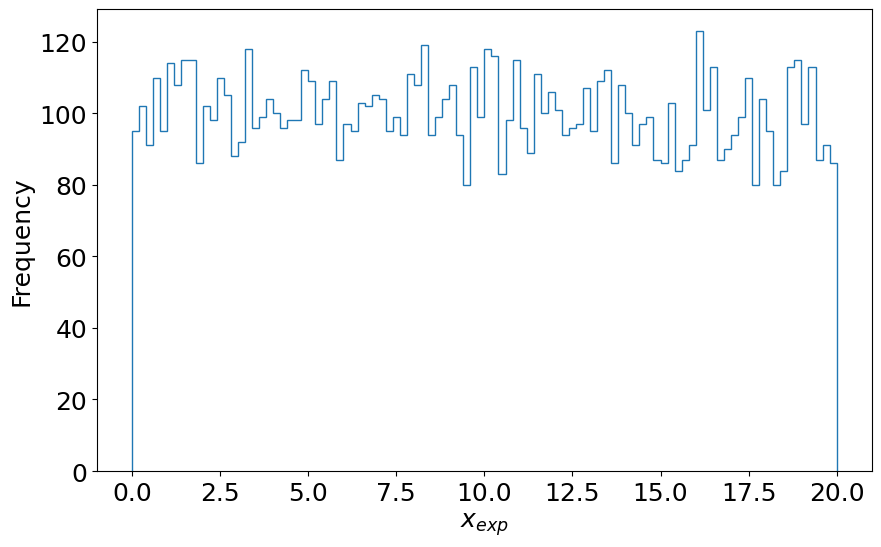

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(x_exp, bins=100, range=(xmin, xmax), histtype='step', label='histogram' )
ax.set(xlabel=r"$x_{exp}$", ylabel="Frequency", xlim=(xmin-1.0, xmax+1.0));

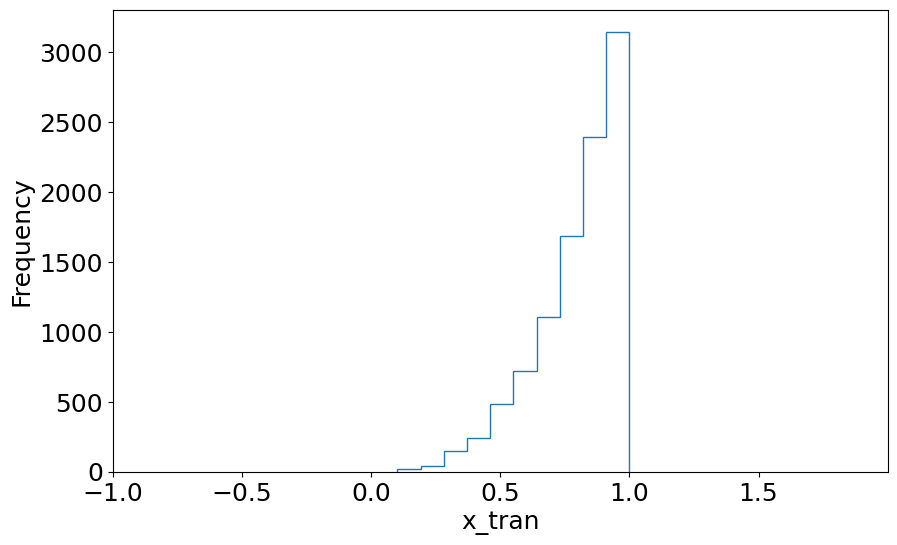

In [33]:
#Inverse transform sampling
x = sp.symbols('x', positive = True)
f = x**3

x_tran = anal_monte_carlo(f, x, (0, 1), N_points, r)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(x_tran, histtype='step', label='histogram' )
#ax.hist(x_tran, bins=100, range=(xmin, np.max(x_tran)), histtype='step', label='histogram' )
ax.set(xlabel="x_tran", ylabel="Frequency", xlim=(xmin-1.0, np.max(x_tran)+1.0));

In [8]:
Max = np.max(np.exp(-x_exp/3))
f_exp = np.exp(-x_exp/3)
f_test = Max*r.uniform(size=N_points)
x_rej = x_exp[f_test<f_exp]
print(len(x_rej))

1505


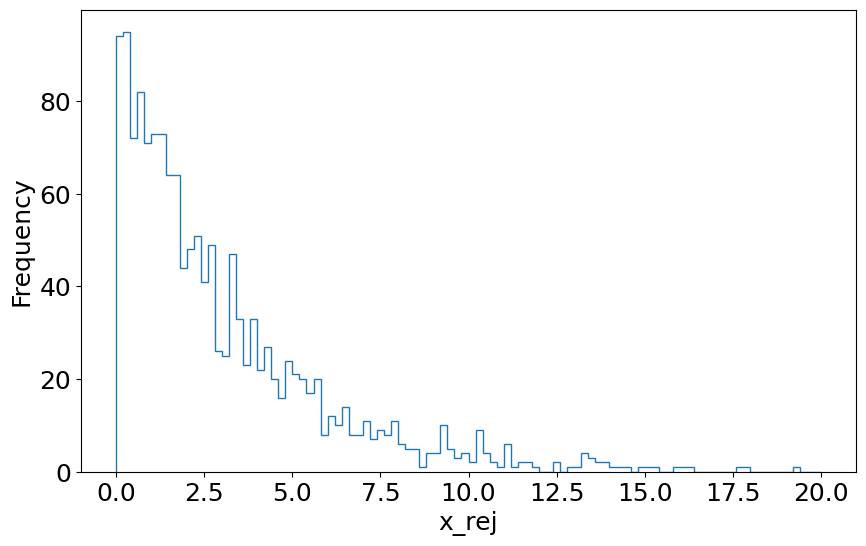

In [9]:
#Plot the rejection sampling
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(x_rej, bins=100, range=(xmin, xmax), histtype='step', label='histogram' )
ax.set(xlabel="x_rej", ylabel="Frequency", xlim=(xmin-1.0, xmax+1.0));


## Problem 2: 

#### Produce random points following $g(x) \sim x \cos(x), x \in [0, \frac{\pi}{2}]$.

In [10]:
xmin2, xmax2 = 0, np.pi/2         # Note the simple/short notation.
ymin, ymax = 0, np.max(np.linspace(0,np.pi/2,1000)*np.cos(np.linspace(0, np.pi/2, 1000)))
N_try = 0
x_accepted = np.zeros(N_points)

for i in range(N_points):
    
    while True:
        
        # Count the number of tries, to get efficiency/integral
        N_try += 1                    
        
        # Range that f(x) is defined/wanted in:
        x_test = r.uniform(xmin2, xmax2)  
        
        # Upper bound for function values:
        y_test = r.uniform(ymin, ymax)
        
        if (y_test < x_test*np.cos(x_test)):
            break
            
    x_accepted[i] = x_test

x_exp2 = xmax2*r.uniform(size=N_points) 


In [11]:
#Using rejection method
Max2 = np.max(np.cos(x_exp2))
f_exp2 = x_exp2*np.cos(x_exp2)
f_test2 = Max2*r.uniform(size=N_points)
x_rej2 = x_exp2[f_test2<f_exp2]


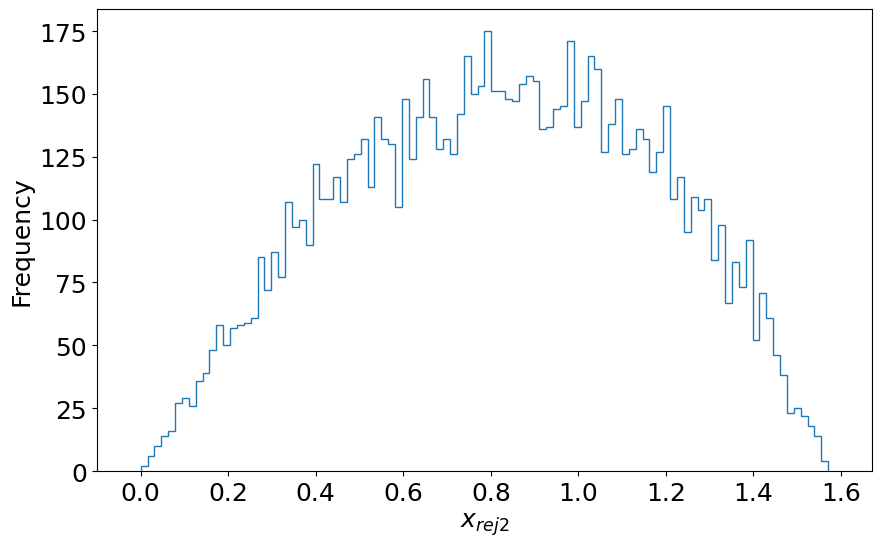

In [12]:
#Plot the rejection sampling
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(x_accepted, bins=100, range=(xmin2, xmax2), histtype='step', label='histogram' )
ax.set(xlabel=r"$x_{rej2}$", ylabel="Frequency", xlim=(xmin2-.1, xmax2+.1));




## Problem 3: 

#### Produce random points following $h(x) \sim \exp(-x/3)\cos(x)^2$ in the interval $[0, \infty]$ and estimate the integral of $h(x)$ in the defined range.

In [13]:
def func(x):
    return np.exp(-x/3)*np.cos(x)**2

In [14]:
def accept_reject_combi(N_points, random, func, gen_func, var, xrange, *args):
    gen_func_lambda = sp.lambdify(var, gen_func)
    F = sp.integrate(gen_func, (var, xrange[0], var))
    integral = sp.integrate(gen_func, (var, *xrange))
    F = F/integral
    F_func = sp.lambdify(var, F)
    u = sp.symbols('u')
    inverse = sp.solve(F - u, var)[0]
    inverse_func = sp.lambdify(u, inverse)
    N_tries = 0
    accepted = []
    for i in range(N_points):
        while True:
            N_tries += 1
            x_test = inverse_func(random.uniform())
            y_test = random.uniform(0, gen_func_lambda(x_test))
            if y_test < func(x_test, *args):
                break
        accepted.append(x_test)
    return accepted, N_tries

In [15]:
x = sp.symbols('x')
test = sp.exp(-x)
test_lamb = sp.lambdify(x, test)
sp.limit(test, x, 9)


exp(-9)

In [16]:
x = sp.symbols('x')
gen_func = sp.exp(-x/3)
#def test_func(x):
    #return np.exp(-x/3)
#def inv_func(x):
    #return -3*np.log(1-x)
F = sp.integrate(gen_func, x)

x_accepted3, N_tries = accept_reject_combi(N_points, r, func, gen_func, x, (0, sp.oo))

In [17]:
#We combine the two methods to get the last distribution
x_accepted2 = np.zeros(N_points)
N_try2 = 0

for i in range(N_points):
    
    while True:
        
        # Count the number of tries, to get efficiency/integral
        N_try2 += 1                    
        
        # Range that f(x) is defined/wanted in:
        x_test = -3*np.log(1-r.uniform(size=1))
        
        # Upper bound for function values:
        y_test = r.uniform(0, np.exp(-x_test/3))
        
        if (y_test < func(x_test)):
            break
            
    x_accepted2[i] = x_test

eff = N_points/N_try
integral = eff*3
integral

1.9378593114139913

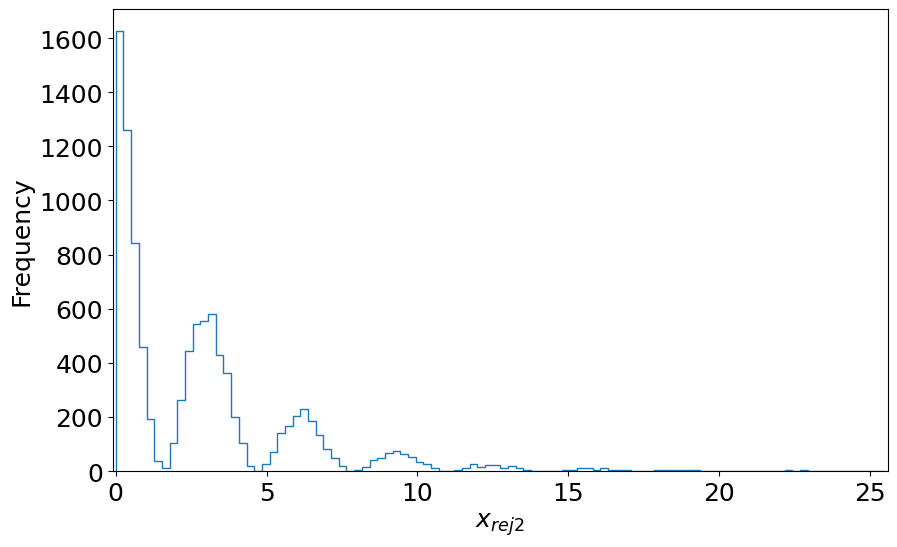

In [18]:
#plot histogram of accepted 2
xmax3 = np.max(x_accepted3)
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(x_accepted3, bins=100, range=(xmin, xmax3), histtype='step', label='histogram' )
ax.set(xlabel=r"$x_{rej2}$", ylabel="Frequency", xlim=(xmin-.1, xmax3+.1));


# Learning points:

While you should by now be able to solve problem 1+2 with at least one of the methods, problem 3 is harder, and requires the combination of the two. Solving this exercise should make you:
1. "proficient" in using the two standard methods.
2. capable of getting random numbers according to ALL 1D PDFs, bounded/integrable/invertible or not.

The last point of problem 3 should also illustrate, how you can estimate integrals using this method.